
# CRIM Intervals: Families of Melodies

## A. Import Intervals and Other Code

* The first step is to import all the code required for the Notebook
* **`arrow/run`** or **`Shift + Enter`** in the following cell:

In [18]:
import intervals
from intervals import * 
from intervals import main_objs
import intervals.visualizations as viz
import pandas as pd
from pandas.io.json import json_normalize
import re
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from ipywidgets import interact
import pyvis
from pyvis.network import Network
from pyvis import network as net
from IPython.display import display
import requests
import os
import glob as glob
import numpy as np
import random
import inspect
import networkx as nx
import networkx.algorithms.community as nx_comm
from copy import deepcopy
%matplotlib inline

## B. Importing a Piece

### B.1 Import a Piece

In [19]:
piece = importScore('https://crimproject.org/mei/CRIM_Model_0008.mei')

Previously imported piece detected.


Import a **corpus** of pieces (models 1 through 9):

In [20]:
piece_corpus = list()
for i in range(1, 10):
    piece_corpus.append(importScore(f'{"https://crimproject.org/mei/CRIM_Model_000%x.mei" % i}'))
piece_corpus

Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.
Previously imported piece detected.


## N-gram Families: 

<br>

For just **one piece** with **fixed length** ngrams:

In [21]:
# setting up the figure size:
sns.set(rc={'figure.figsize':(15,9)})

Originally, the n-grams reflect the intervals between several entries, which are **magnitudes** and are optimal for computational purposes. However, they don't graphically reflect a musical melody (changes in pitches over time, as the data points themselves are **relative to the previous point**). A visual example might help. 

Let's get **one n-gram** first from **Josquin Des Prés's Ave Maria** (Model \#8):

In [22]:
piece_notes = piece.notes(combineUnisons=True)
piece_melodic = piece.melodic(df=piece_notes, kind="d", end=False)
piece_entries = piece.entries(df=piece_melodic, n=4).fillna('')
one_particular_ngram = list(map(lambda x: int(x), piece_entries.iloc[1]["Altus"]))
one_particular_ngram

[4, 2, 2, -3]

If we **graph this pattern**, we can produce a following line:

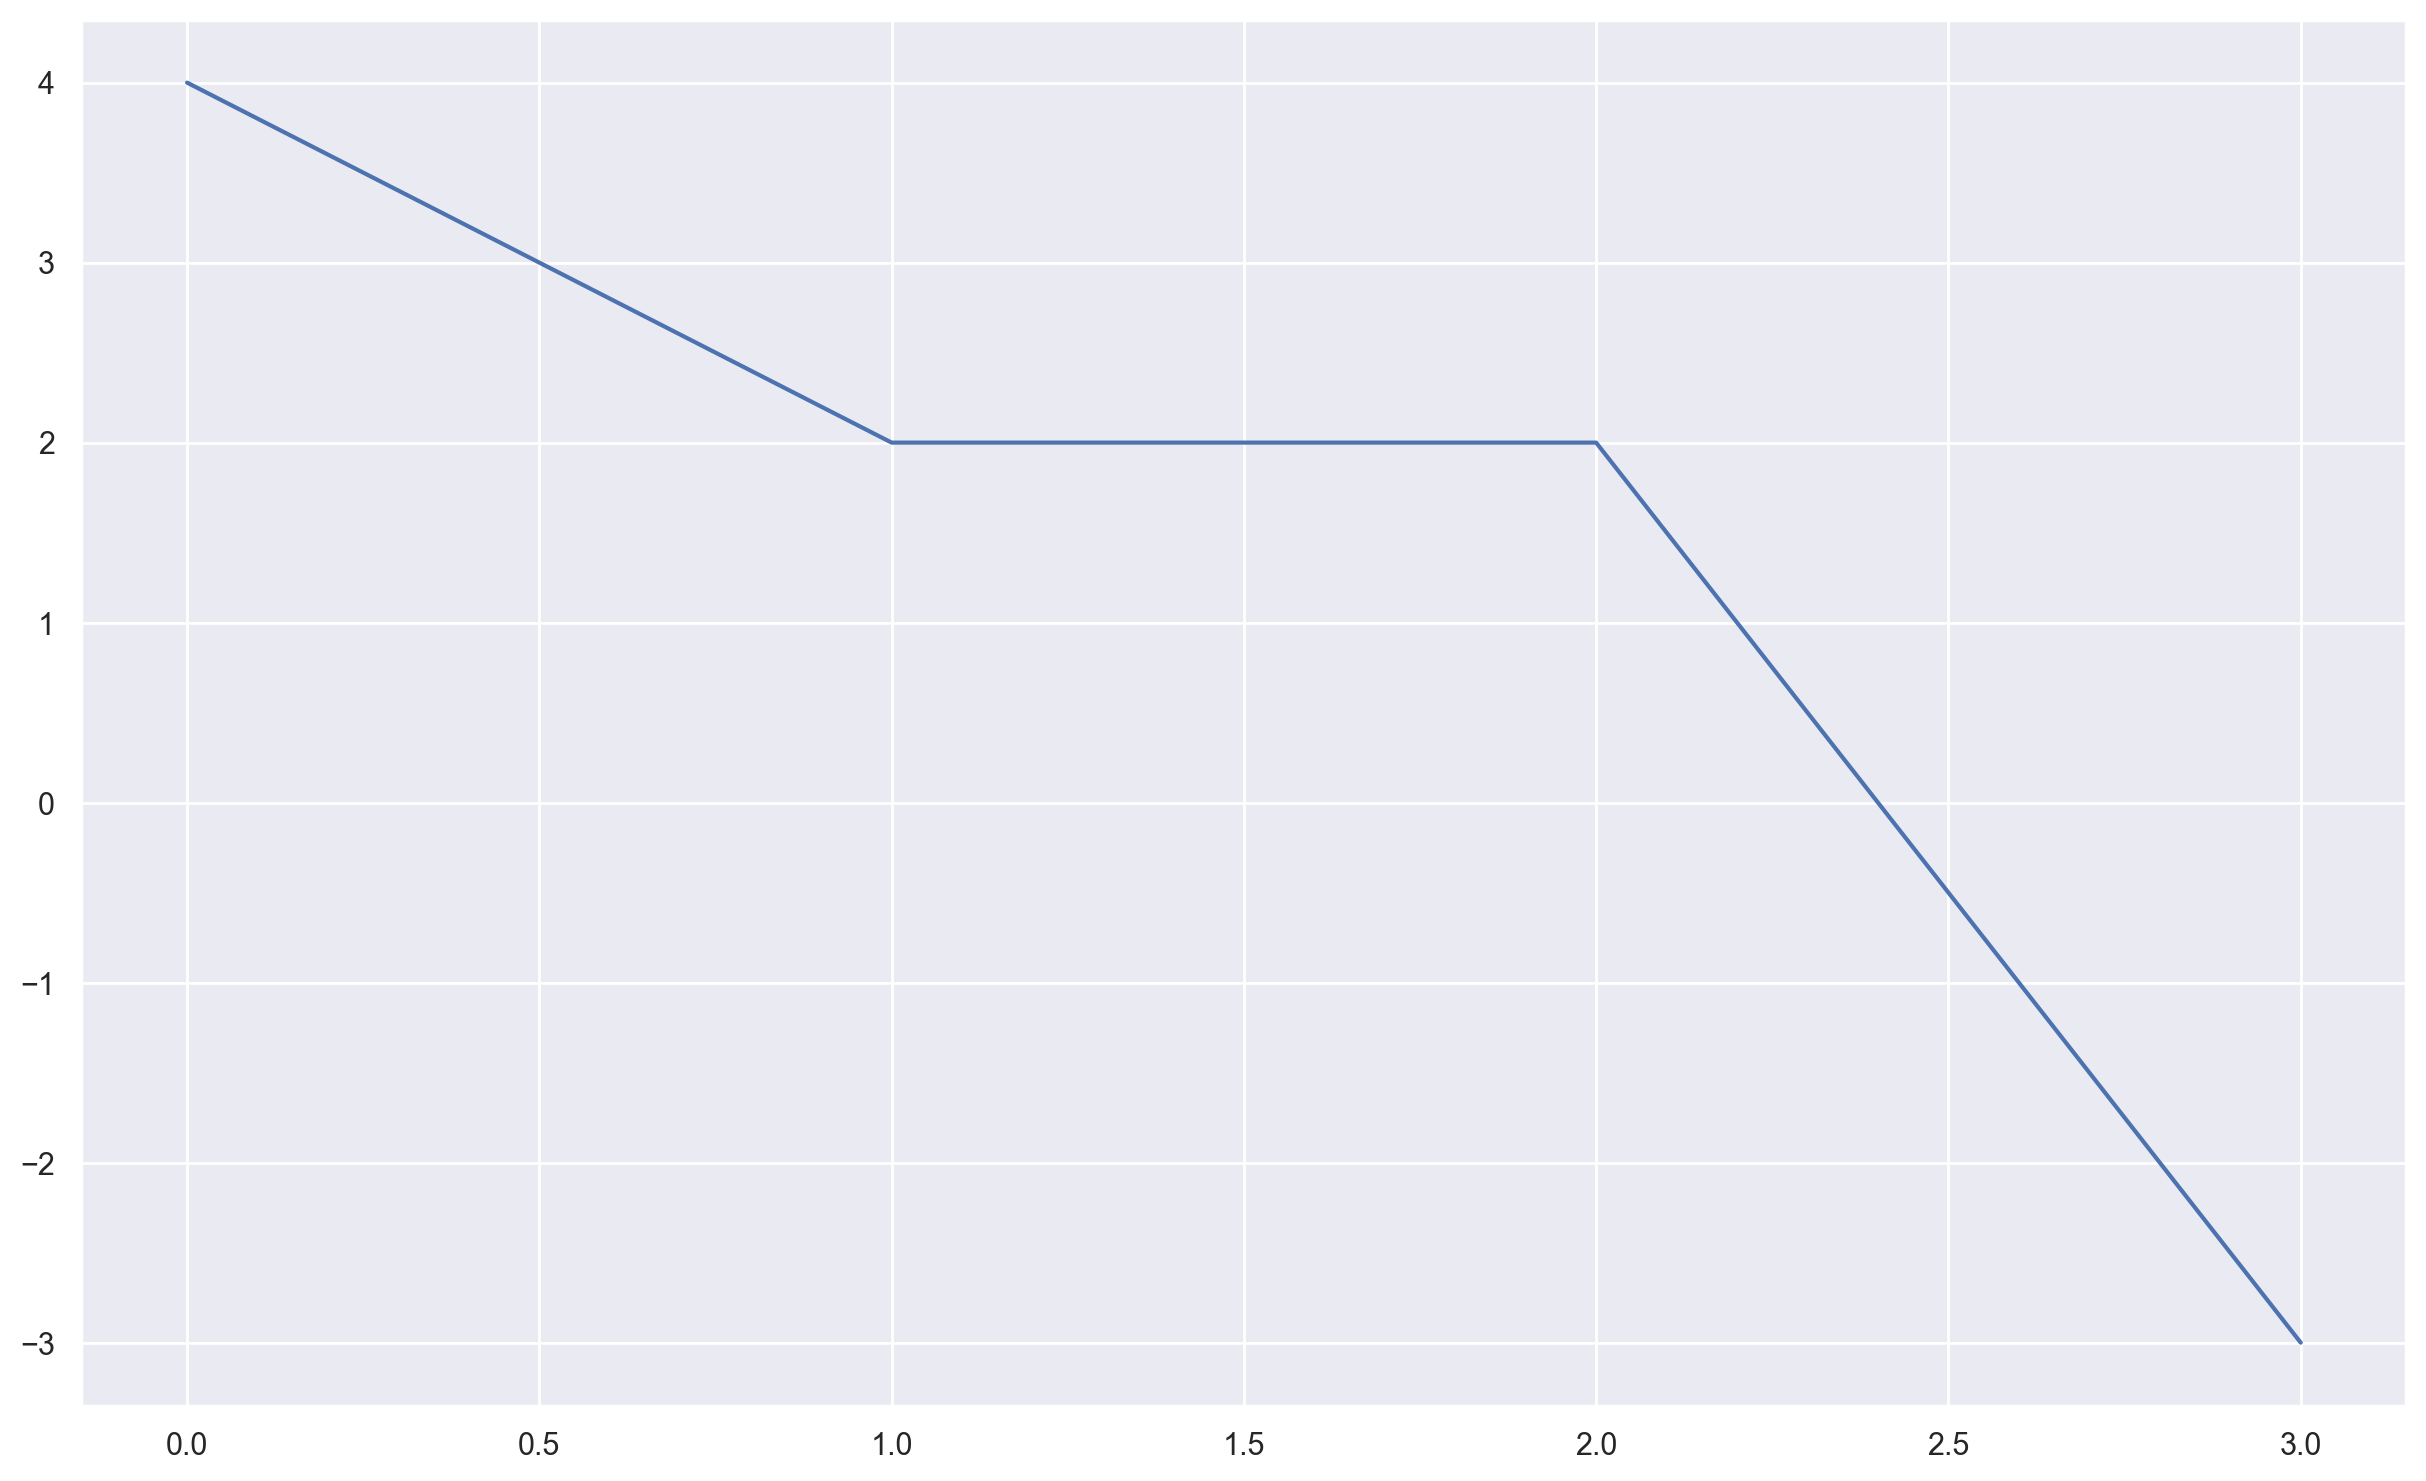

In [23]:
plt.plot(one_particular_ngram)
plt.show()

The are several problems with interpreting this pattern visually:
1. it **starts at 4**: the first entry of the n-gram, "4", is viewed as the starting point on the graph, while in reality it's a change from an **arbitrary pitch point** going 4 up
2. it **represents 3 movements**: since we only show the magnitudes of changes, this representation reflects 3 changes of states, while in reality 4 notes (pitch points) must be produced in order to obtain such pattern
3. it **has different direction**: take the second entry of the pattern ("2"), for example. On the graph below, it is reflected below "4" (first entry), mainly 2 points. This also maxes it **2 points below** where we started. In reality, however, after playing "4, 2", we would end up **6 points above** where we started. This happens because mathematically this representation of a musical pattern is **its derivative** as it once again reflects the magnitudes of changes. 

Hence, we need a tool to make a pattern graphable, mainly through **integrating the total change** and **adding an origin** – "0", to make all things relative. We need a function that transforms an interval pattern into a **graphable interval series**, visually reflecting the movements of the pattern:

In [24]:
def patternToSeries(pattern):
    output_list = []
    output_list.append(0)
    output_list.append(pattern[0])
    for i in range(1, len(pattern)):
        output_list.append(sum(pattern[0:i]) + pattern[i])
    return output_list

Using this function to **transform the initial pattern**:

In [25]:
# sample pattern to series:
patternToSeries(one_particular_ngram)

[0, 4, 6, 8, 5]

As you can see, now the initial n-gram is defined as a movement of the pitch relative to an arbitrary point of origin ("0" in this case). 

Let's **graph** it:

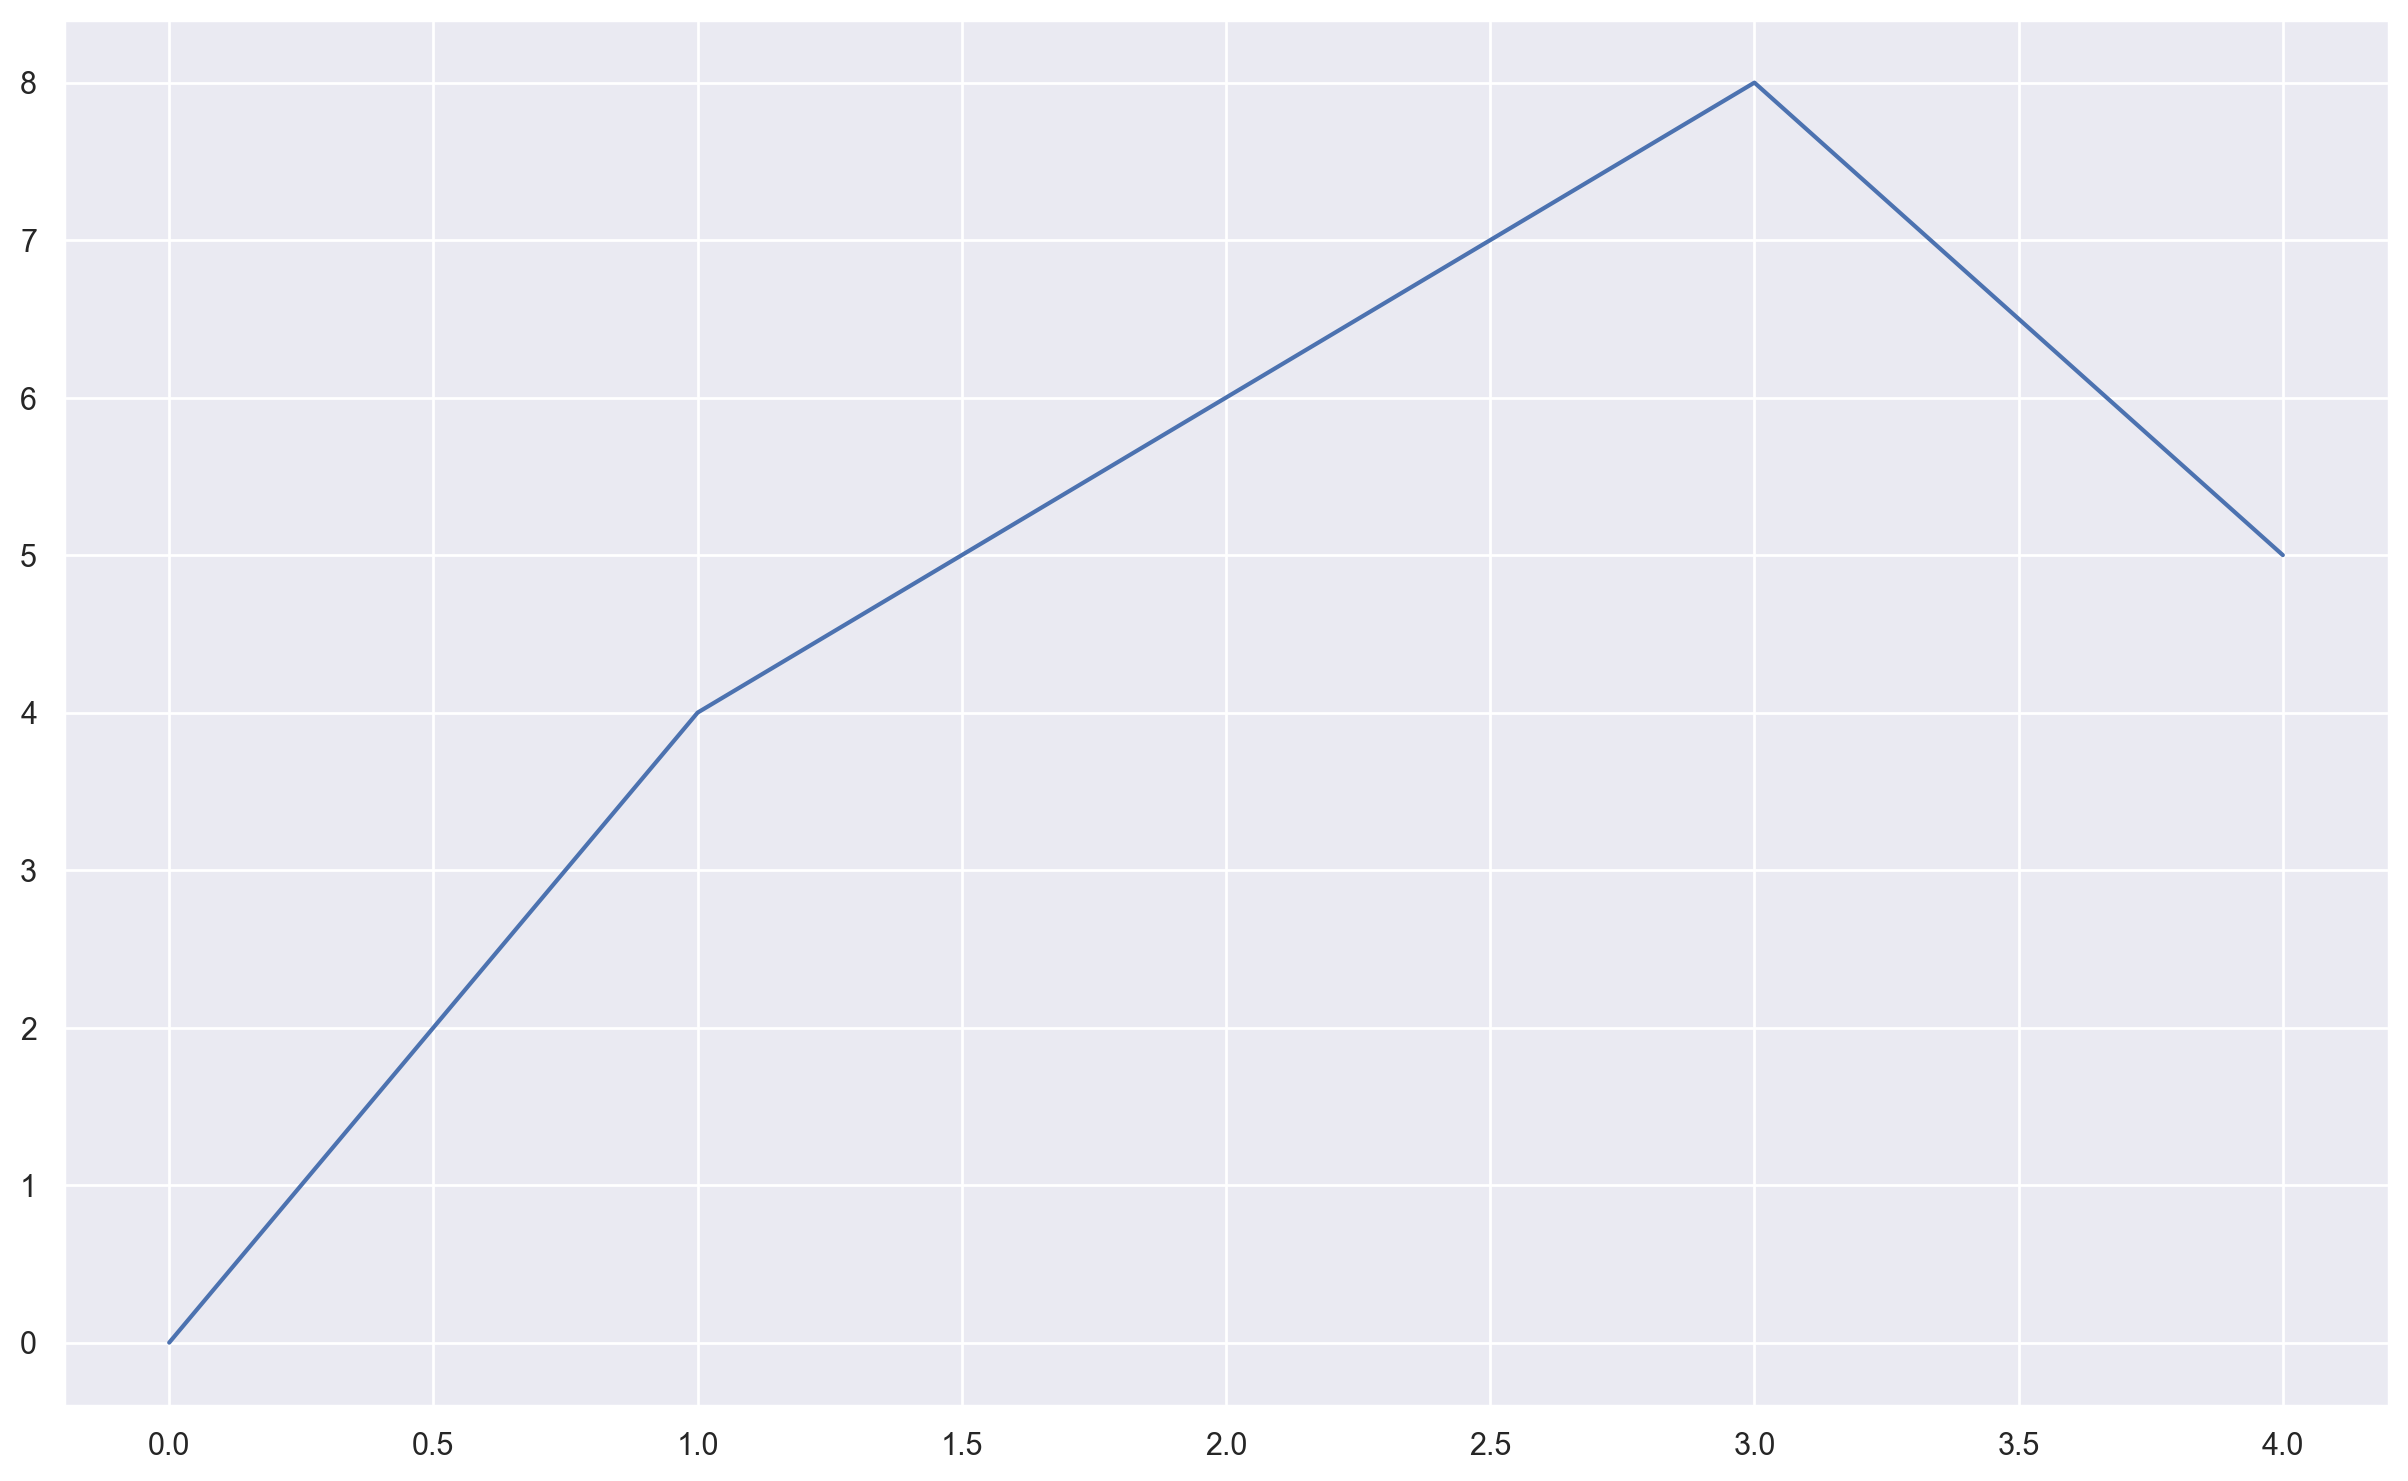

In [26]:
plt.plot(patternToSeries(one_particular_ngram))
plt.show()

As we can see above, the transformed pattern **reflects the actual musical movement** of its melody.

Next, we create a function that runs *patternToSeries* on a **list of patterns**:

In [27]:
def createGraphList(pattern_list):
    graph_list = []
    for item in pattern_list:
        temp_item = list(map(lambda x: int(x), item))
        graph_list.append(patternToSeries(temp_item))
    return graph_list

## Working with a Piece:

Finally, here's a multi-module function that **graphs interval families** for a piece.

Parameters include:
* **piece**: a Piece object to get the patterns from
* **length**: the \[maximum\] length of desirable n-grams
* **combineUnisons**: True by default, could be played with
* **kind**: "d" by default; hard to toggle as we need lists of numbers
* **end**: "False" by default
* **variableLenght**: include n-grams with lenght up to specified length (if True), otherwise include n-grams of just the specified length (if False); False by default
* **suggestedPattern**: include n-grams that start with a specific pattern (need to provide a tuple of strings), otherwise returns all patterns (if False); False by default

In [28]:
def graphIntervalFamilies(piece, length, combineUnisons=True, kind="d", end=False, variableLength=False, suggestedPattern=None, useEntries=True):
    local_ngrams = pd.DataFrame(columns=piece.notes().columns)
    
    if variableLength:
        loop_start = 1
    else:
        loop_start = length
        
    for i in range(loop_start, length + 1):  
        loop_notes = piece.notes(combineUnisons=True)
        loop_melodic = piece.melodic(df=loop_notes, kind=kind, end=end)
        if useEntries:     
            loop_ngrams = piece.entries(df=loop_melodic, n=int(i)).fillna('')
        else:
            loop_ngrams = piece.ngrams(df=loop_melodic, n=int(i)).fillna('')
        local_ngrams = pd.concat([local_ngrams, loop_ngrams])
        
    total_unique_ngrams_list = list(filter(lambda x: x != "", list(set(local_ngrams.values.flatten().tolist()))))
    if suggestedPattern:
        matching_unique_ngrams_list = list(map(lambda x: x if ",".join(x).startswith(",".join(suggestedPattern)) else "", total_unique_ngrams_list))
        total_unique_ngrams_list = list(filter(lambda x: x != "", matching_unique_ngrams_list))

    graph_pattern_list = createGraphList(total_unique_ngrams_list)
    
    for pattern in graph_pattern_list:
        plt.plot(pattern, alpha=0.35, lw=6)
    plt.yticks(np.arange(min(list(map(lambda x: sorted(x)[0], graph_pattern_list))) - 1, max(list(map(lambda x: sorted(x)[-1], graph_pattern_list))) + 1, 1.0))
    plt.xticks(np.arange(0, max(list(map(lambda x: len(x), graph_pattern_list))), 1.0))
    plt.title("Total Number of Patterns: " + str(len(graph_pattern_list)) + "\n Piece Name: " + piece.metadata["title"])
    plt.show()

Graphing the Interval Families for **Josquin Des Prés's Ave Maria** with `length=4` and `useEntries=True`):

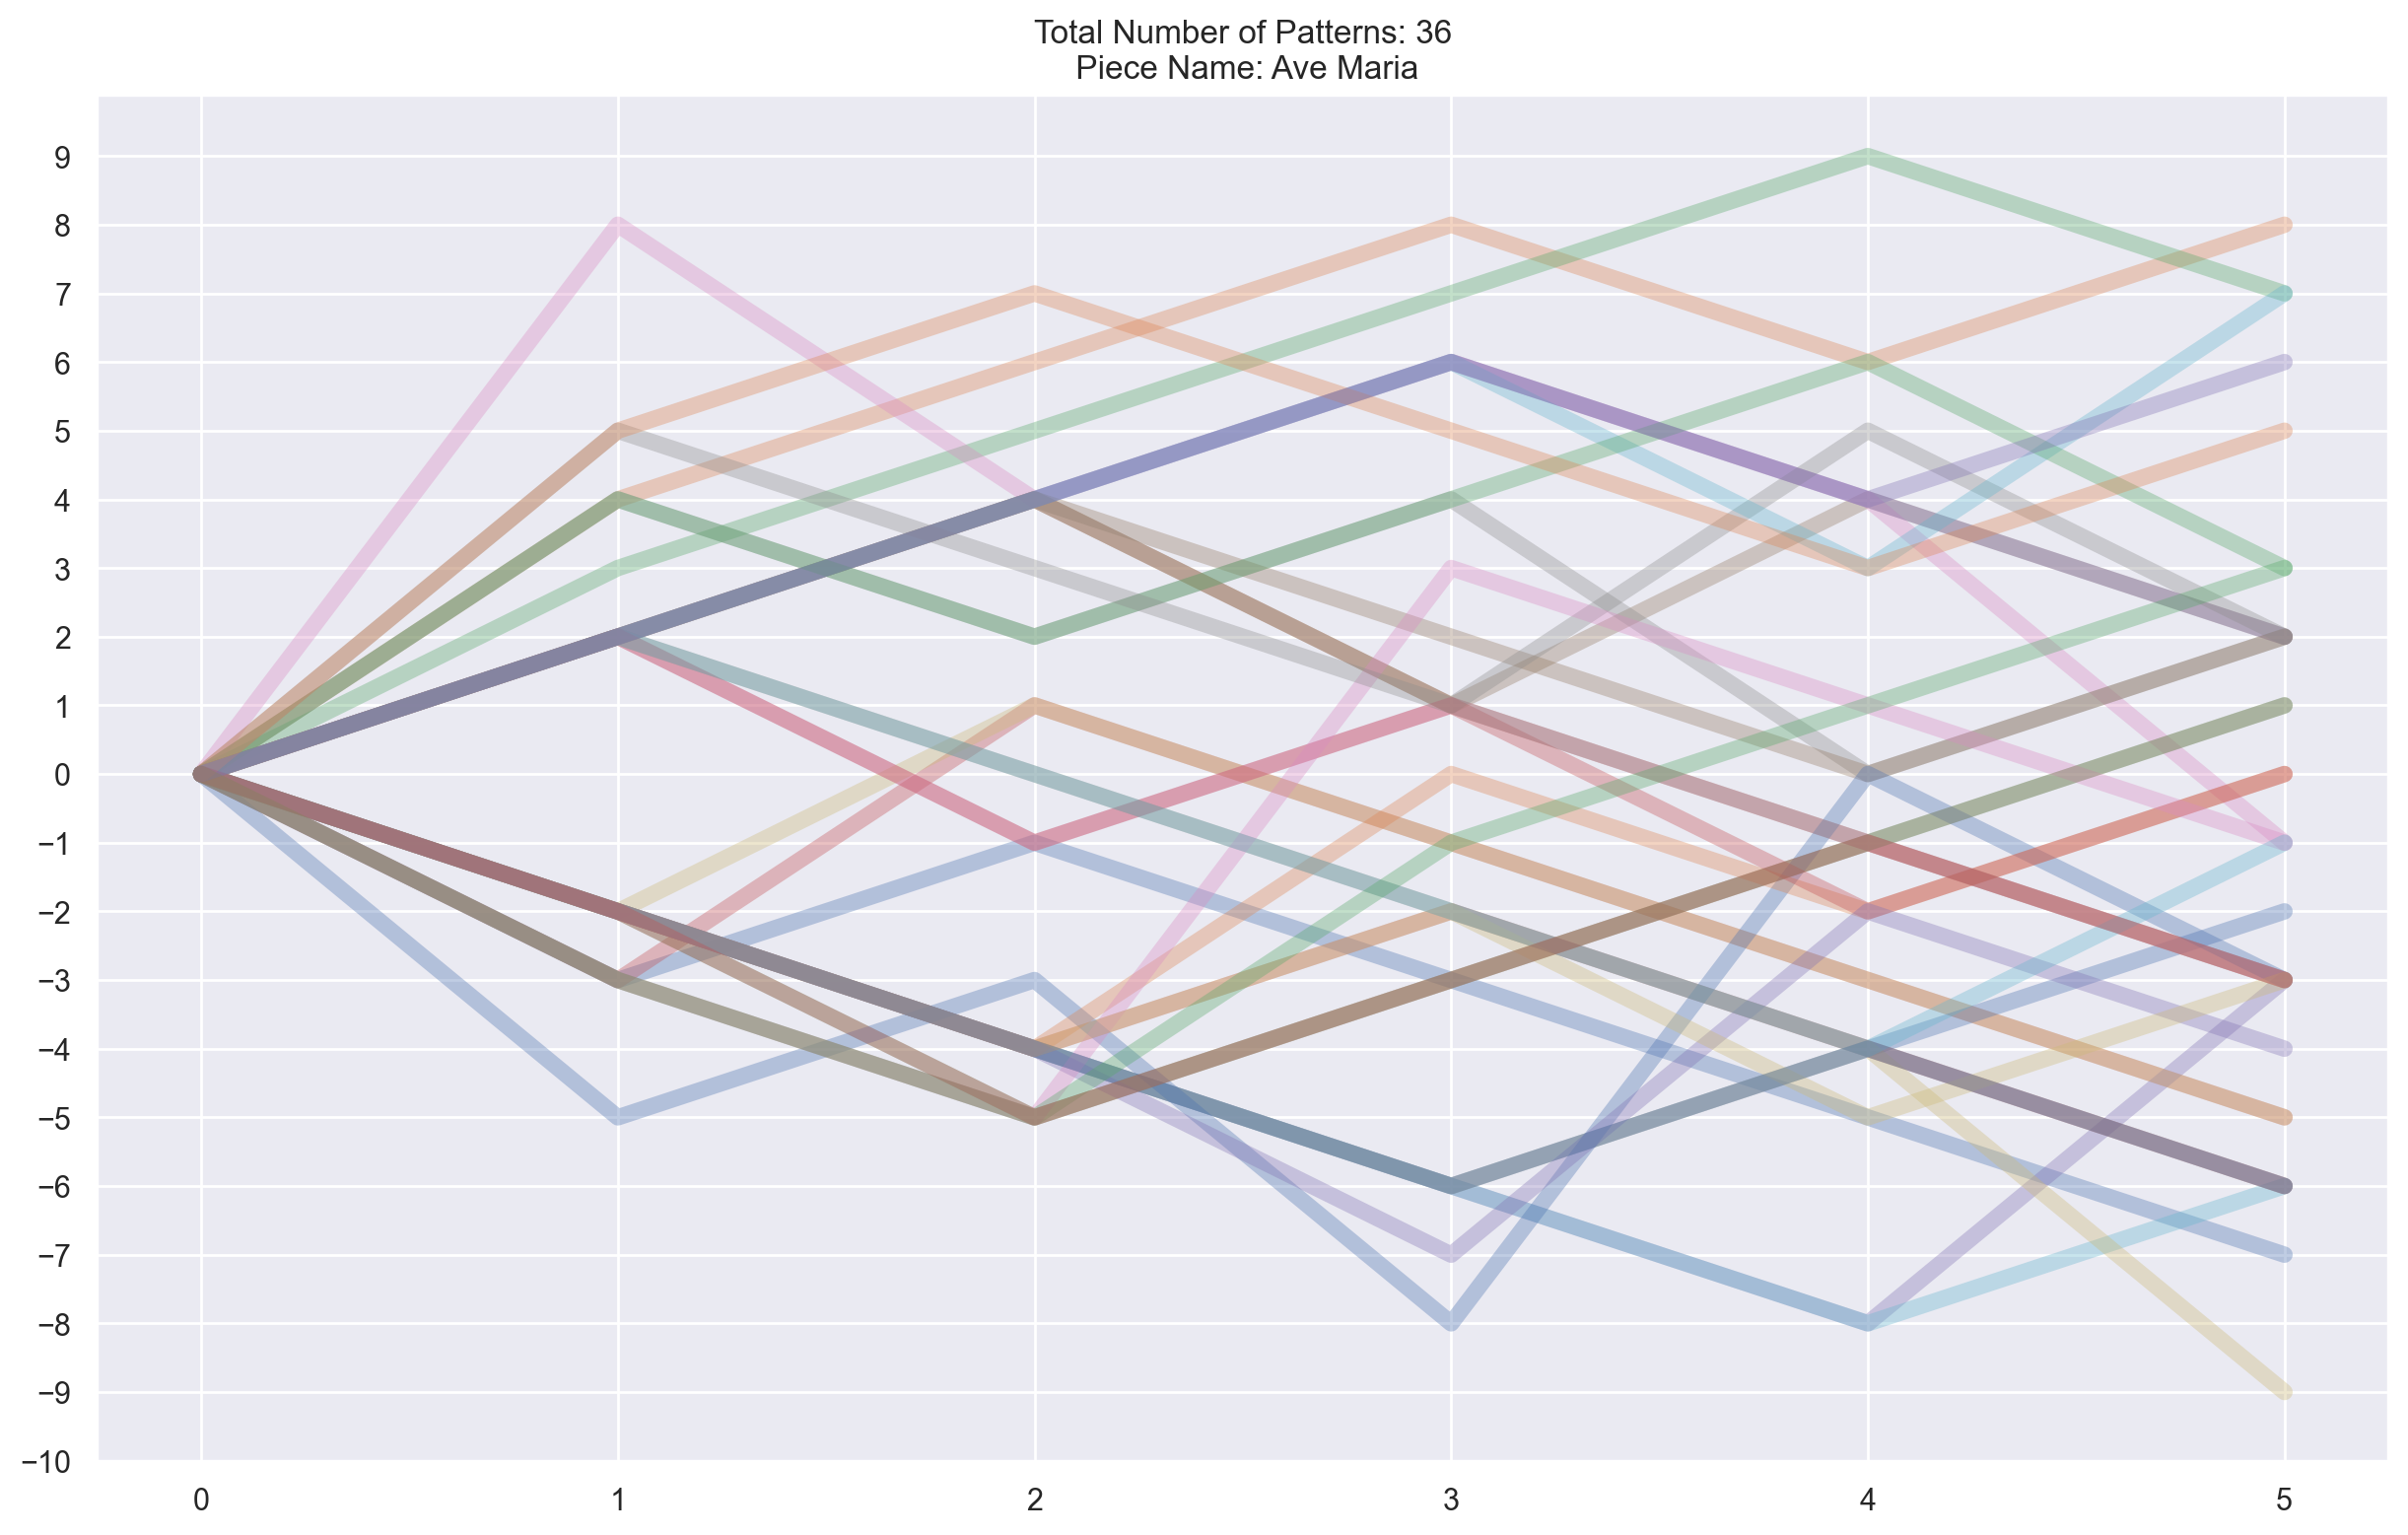

In [13]:
graphIntervalFamilies(piece, 5, useEntries=True)

Another useful option is `variableLength=True`, therefore including **all unique patterns up to the specified length**:

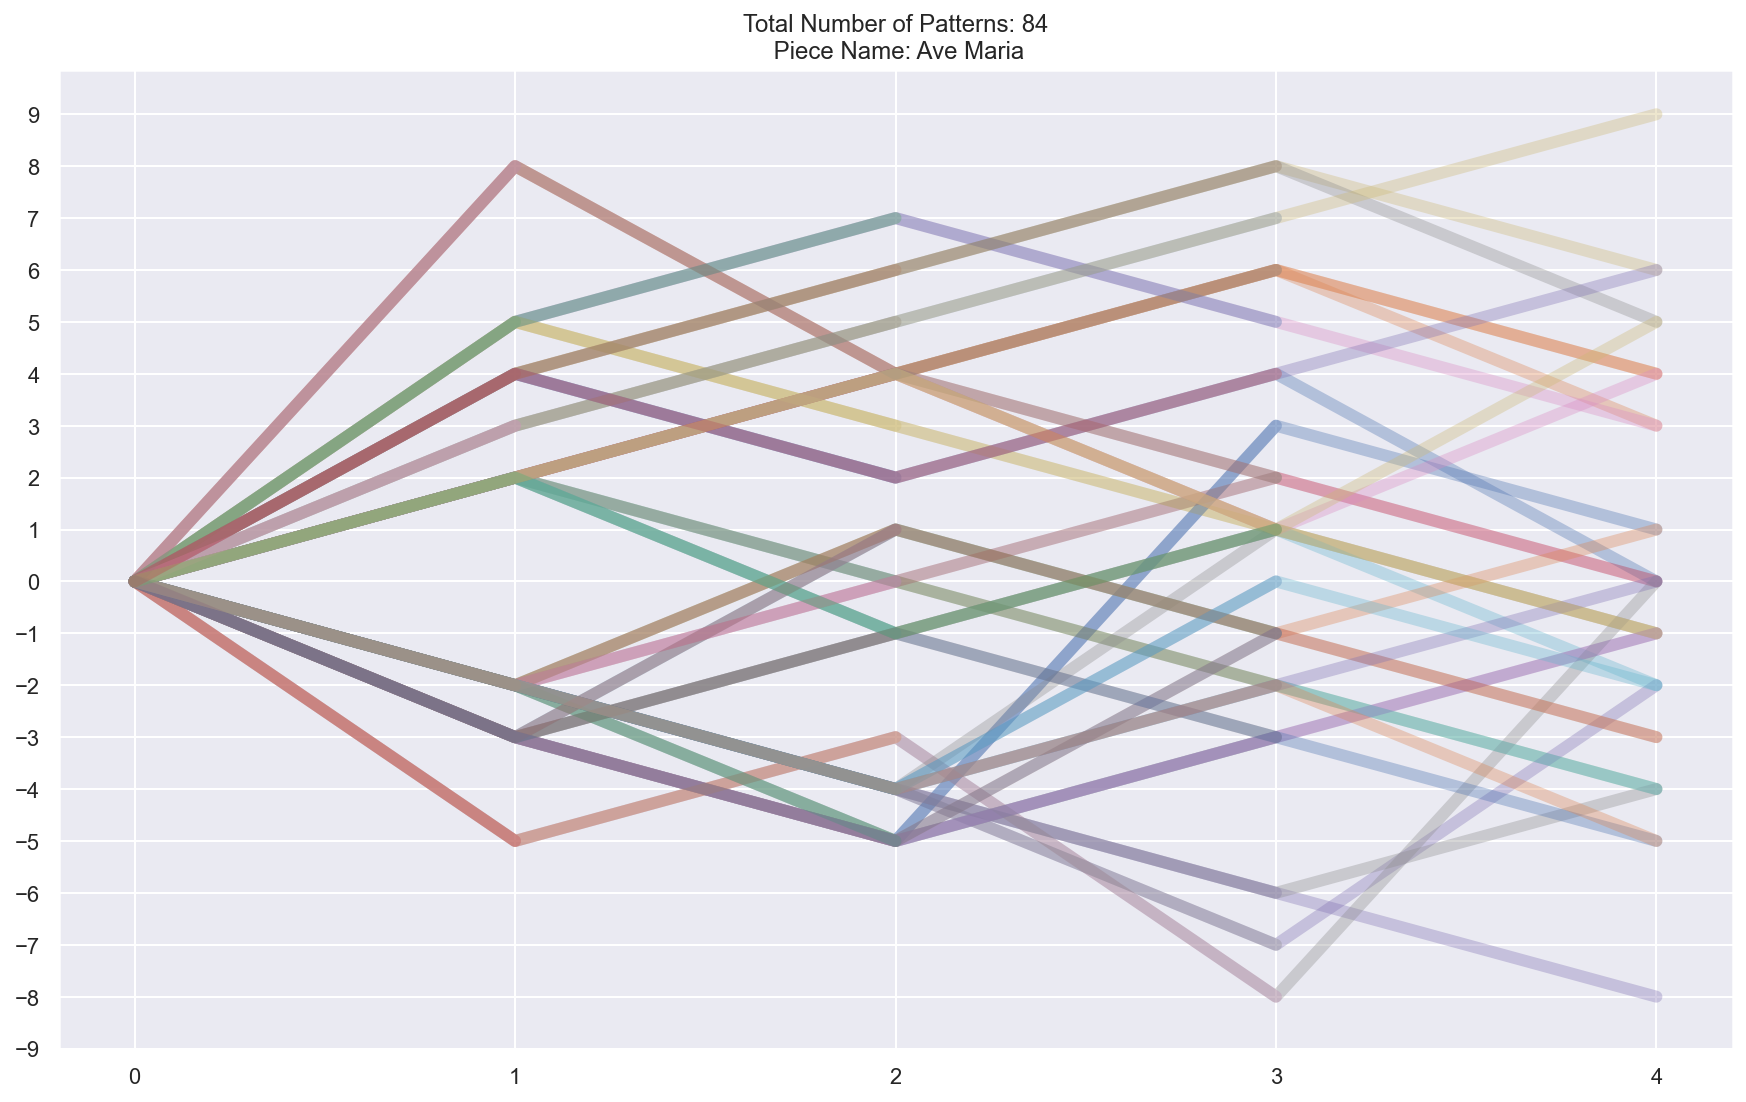

In [188]:
graphIntervalFamilies(piece, 4, variableLength=True)


Finally, we can narrow down patterns of interested by specifying `suggestedPattern=Tuple(Str*)`, for example looking for **all patterns that start with `-2, -2`**:

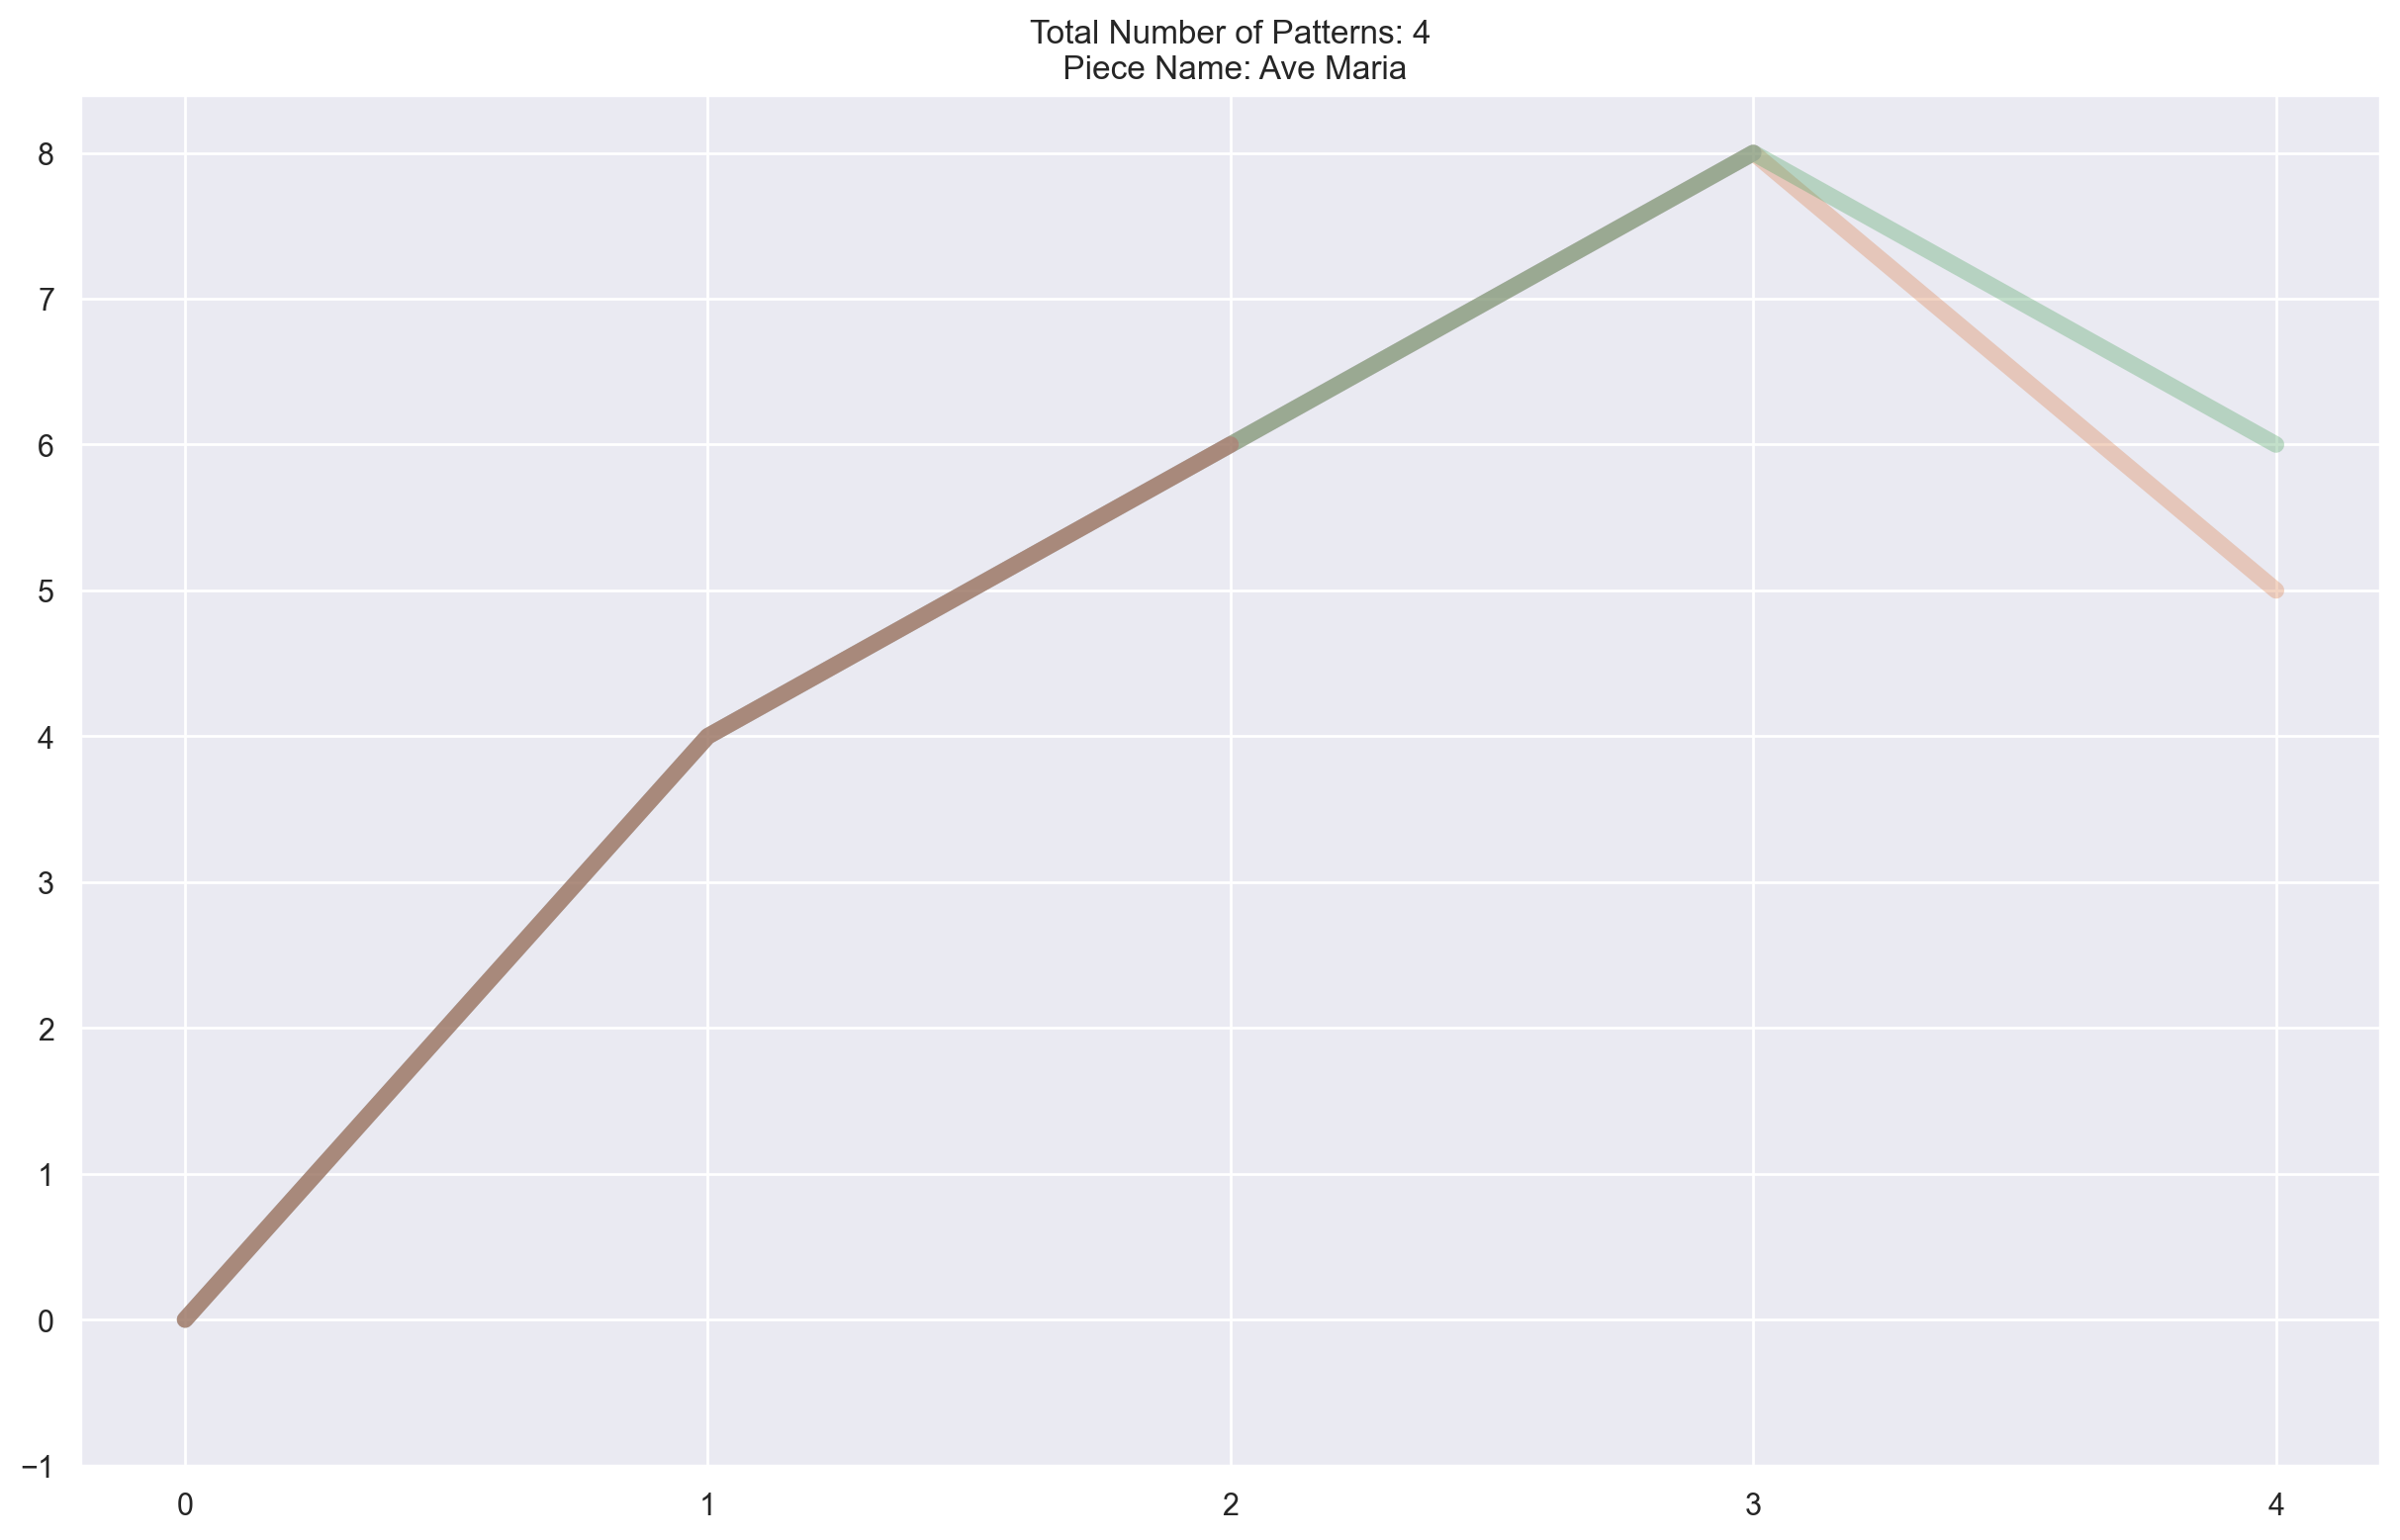

In [14]:
graphIntervalFamilies(piece, 4, variableLength=True, suggestedPattern=("4", "2"))


## Working with a Corpus:

Similarly to the `graphIntervalFamilies` method above, we define the `compareIntervalFamilies` method, which graphs Interval Families for a list of pieces. It's arguments follow those of the single-piece method:

In [15]:
def compareIntervalFamilies(pieces_list, length, combineUnisons=True, kind="d", end=False, variableLength=False, suggestedPattern=None, useEntries=True):
    names_of_pieces = ""
    number_of_patterns = 0
    for piece_item in pieces_list:
        local_color =  f'{"#%06x" % random.randint(0, 0xFFFFFF)}'
        local_ngrams = pd.DataFrame(columns=piece_item.notes().columns)

        if variableLength:
            loop_start = 1
        else:
            loop_start = length

        for i in range(loop_start, length + 1):  
            loop_notes = piece_item.notes(combineUnisons=combineUnisons)
            loop_melodic = piece_item.melodic(df=loop_notes, kind=kind, end=end)
            if useEntries:     
                loop_ngrams = piece_item.entries(df=loop_melodic, n=int(i)).fillna('')
            else:
                loop_ngrams = piece_item.ngrams(df=loop_melodic, n=int(i)).fillna('')
            local_ngrams = pd.concat([local_ngrams, loop_ngrams])

        total_unique_ngrams_list = list(filter(lambda x: x != "", list(set(local_ngrams.values.flatten().tolist()))))
        if suggestedPattern:
            matching_unique_ngrams_list = list(map(lambda x: x if ",".join(x).startswith(",".join(suggestedPattern)) else "", total_unique_ngrams_list))
            total_unique_ngrams_list = list(filter(lambda x: x != "", matching_unique_ngrams_list))

        graph_pattern_list = createGraphList(total_unique_ngrams_list)
        
        number_of_patterns += len(graph_pattern_list)
        names_of_pieces += ("\n" + piece_item.metadata["title"])
        for single_pattern in graph_pattern_list:
            plt.plot(single_pattern, alpha=0.35, lw=6, color=local_color)
            
    plt.yticks(np.arange(-15, 15, 1.0))
    plt.xticks(np.arange(0, length + 1, 1.0))
    plt.title("Total Number of Patterns: " + str(number_of_patterns) + "\n Piece Names: " + names_of_pieces)
    plt.show()

Comparing the Interval Families with `length=4` and `variableLength=True` for **Johannes Lupi's *Veni Speciosam*** and **Thomas Champion's *O Gente Brunette***:

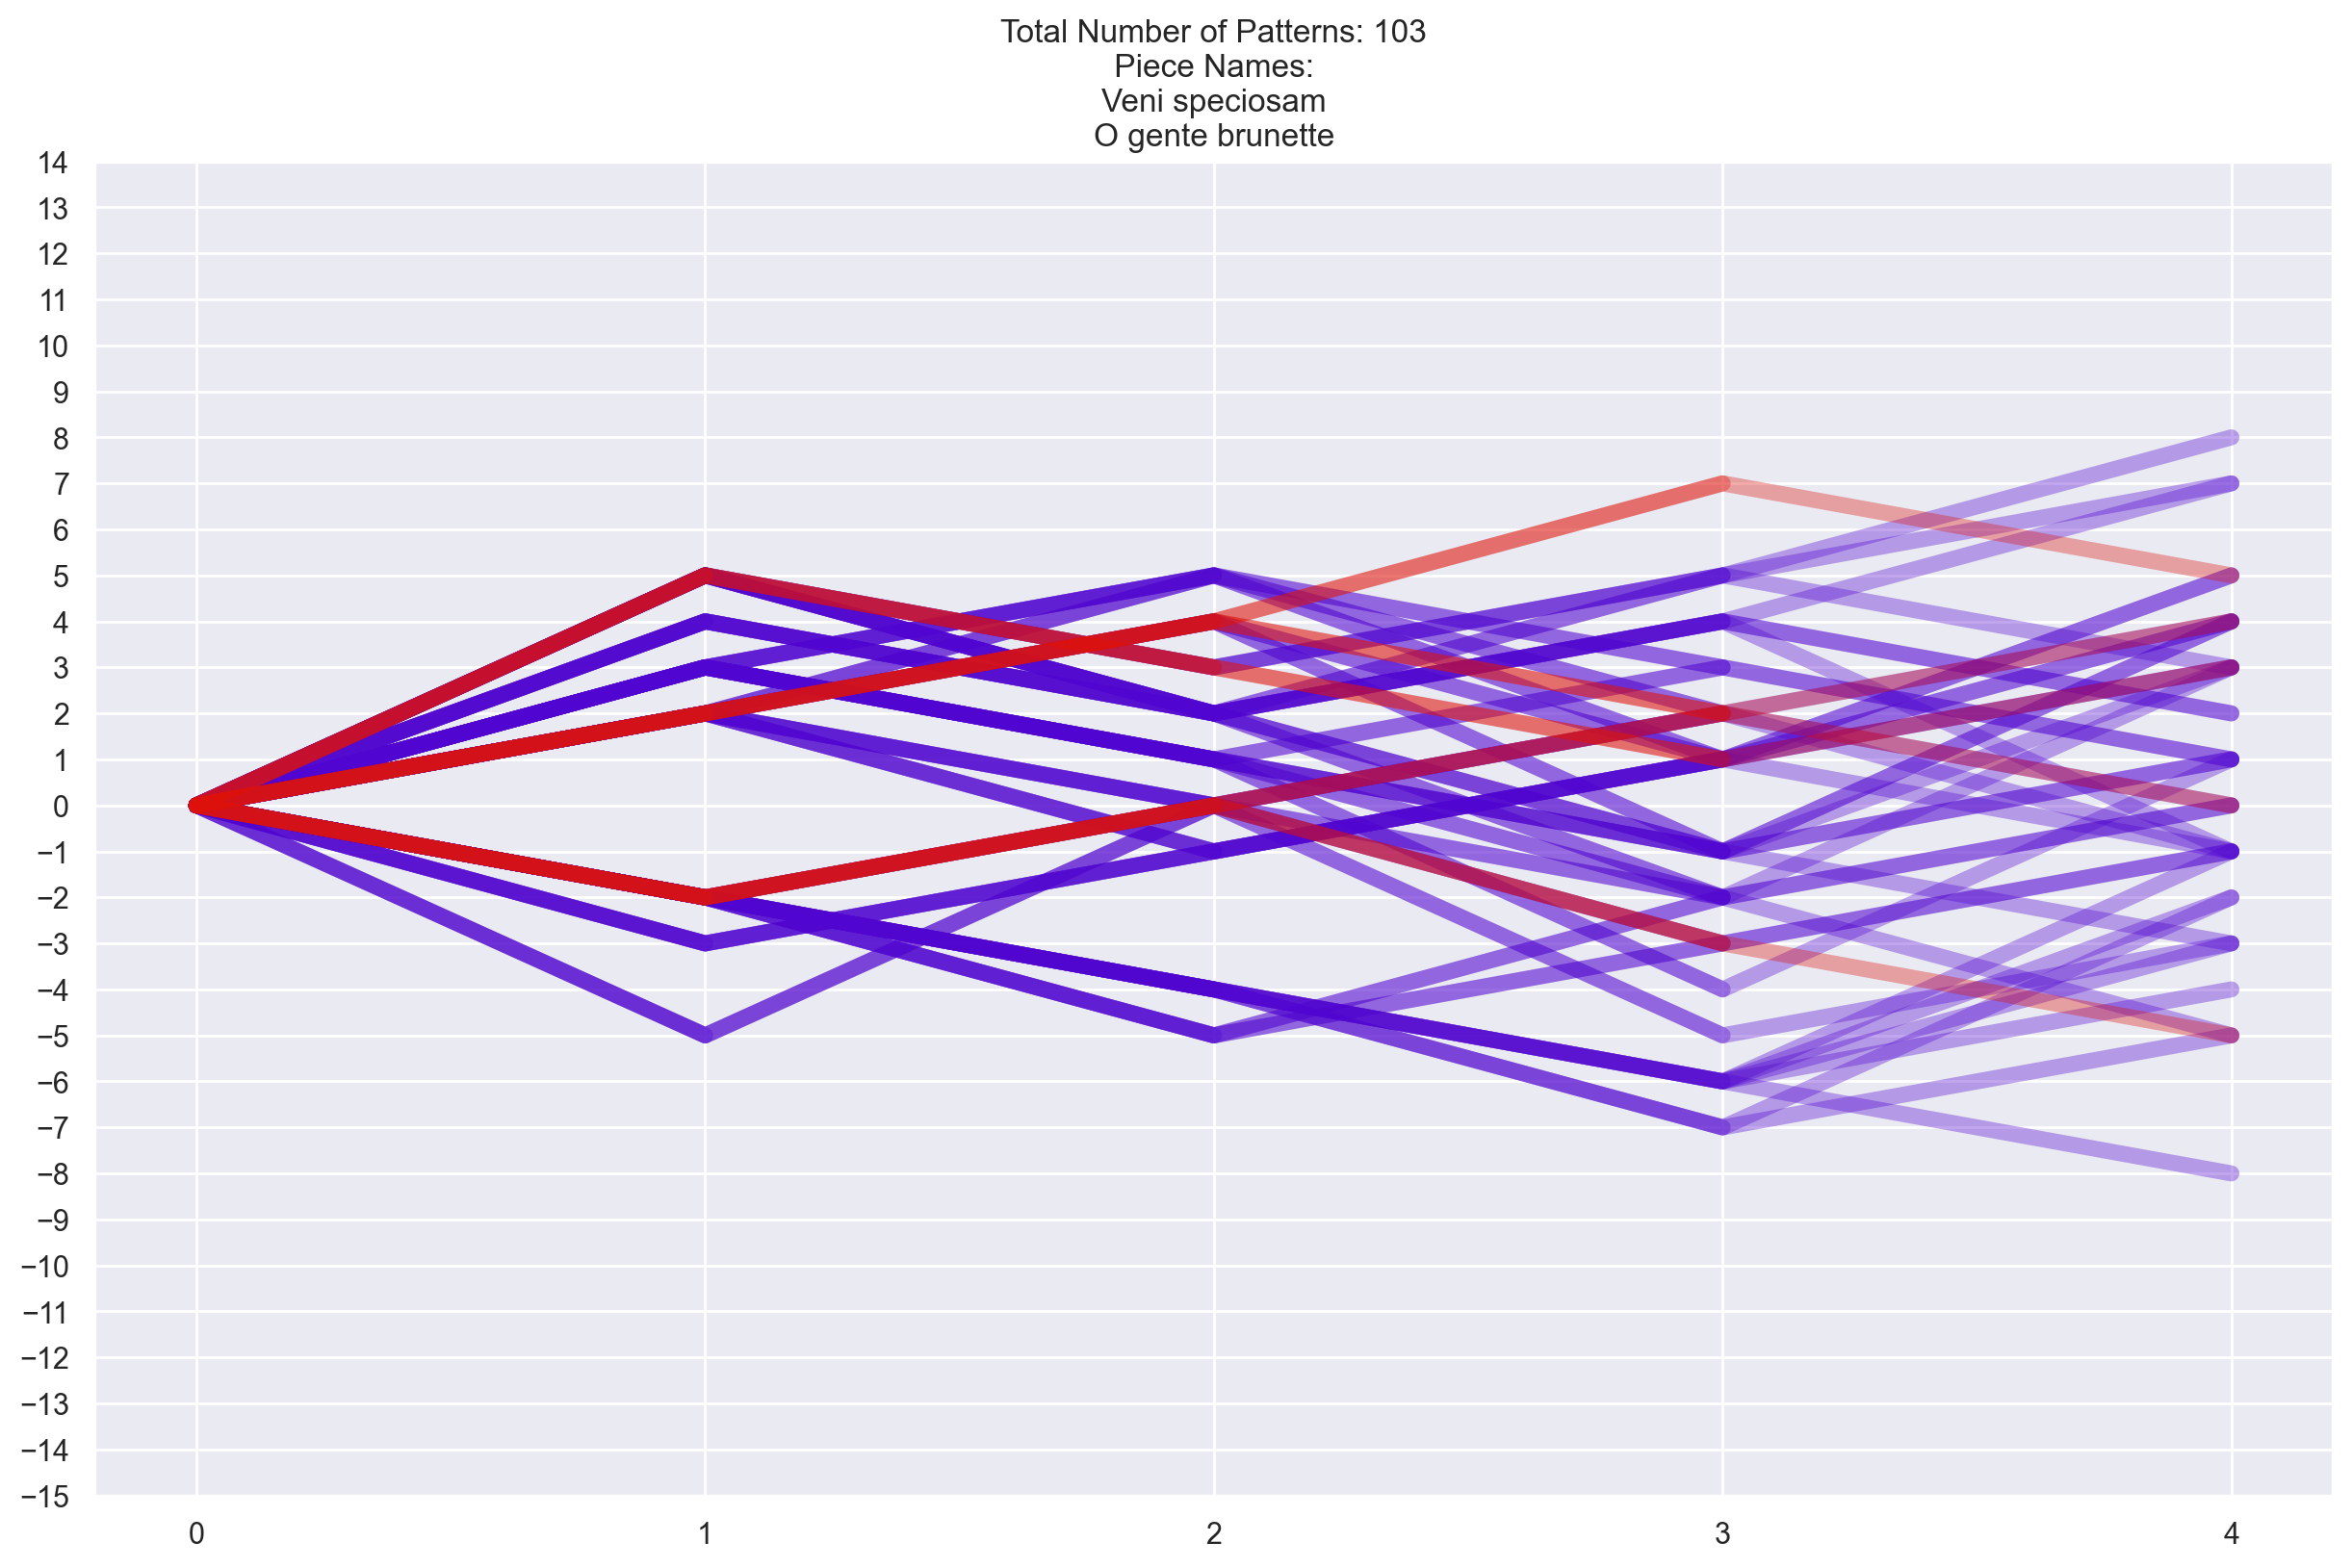

In [16]:
compareIntervalFamilies(piece_corpus[0:2], 4, variableLength=True, useEntries=True)

In the case of two pieces, one might be interested in comparing all branchings after a certain interval – say, **a Fifth up**. This could be accomplished by specifying `suggestedPattern=("5",)`:

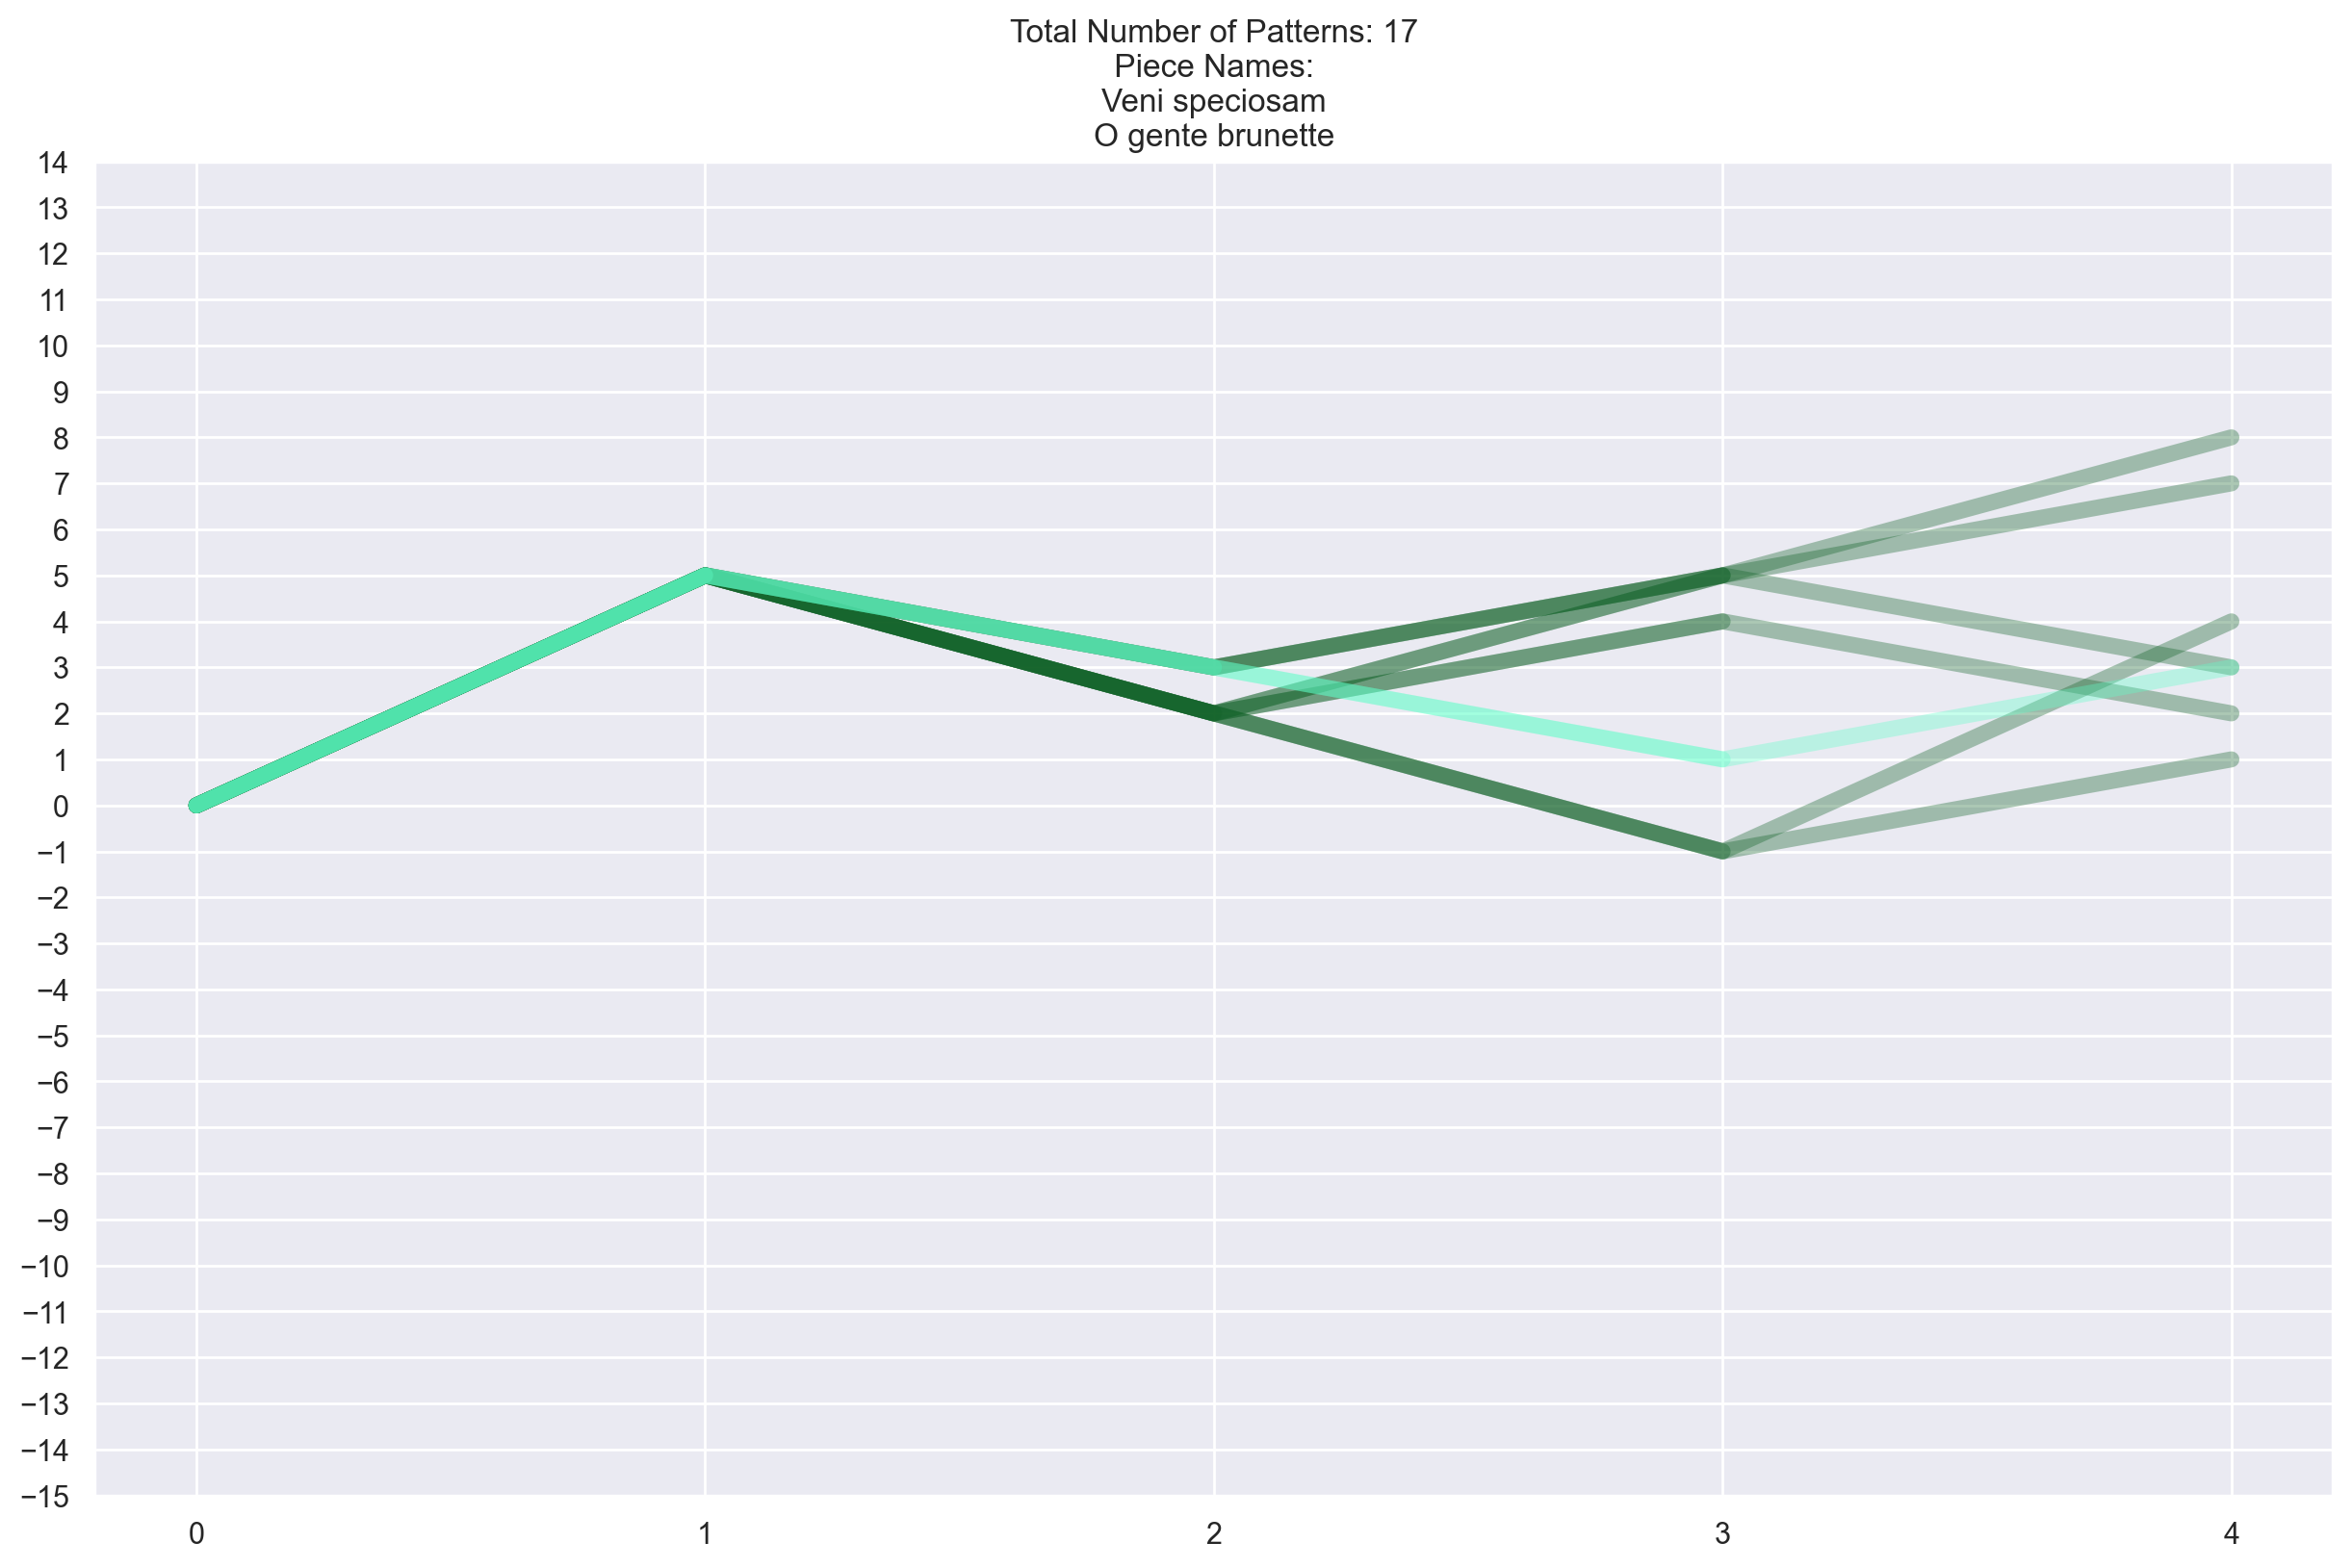

In [17]:
compareIntervalFamilies(piece_corpus[0:2], 4, variableLength=True, useEntries=True, suggestedPattern=("5",))

Although the following produces a messier result, it's possible to compare the interval families for an **entire corpus of pieces**:

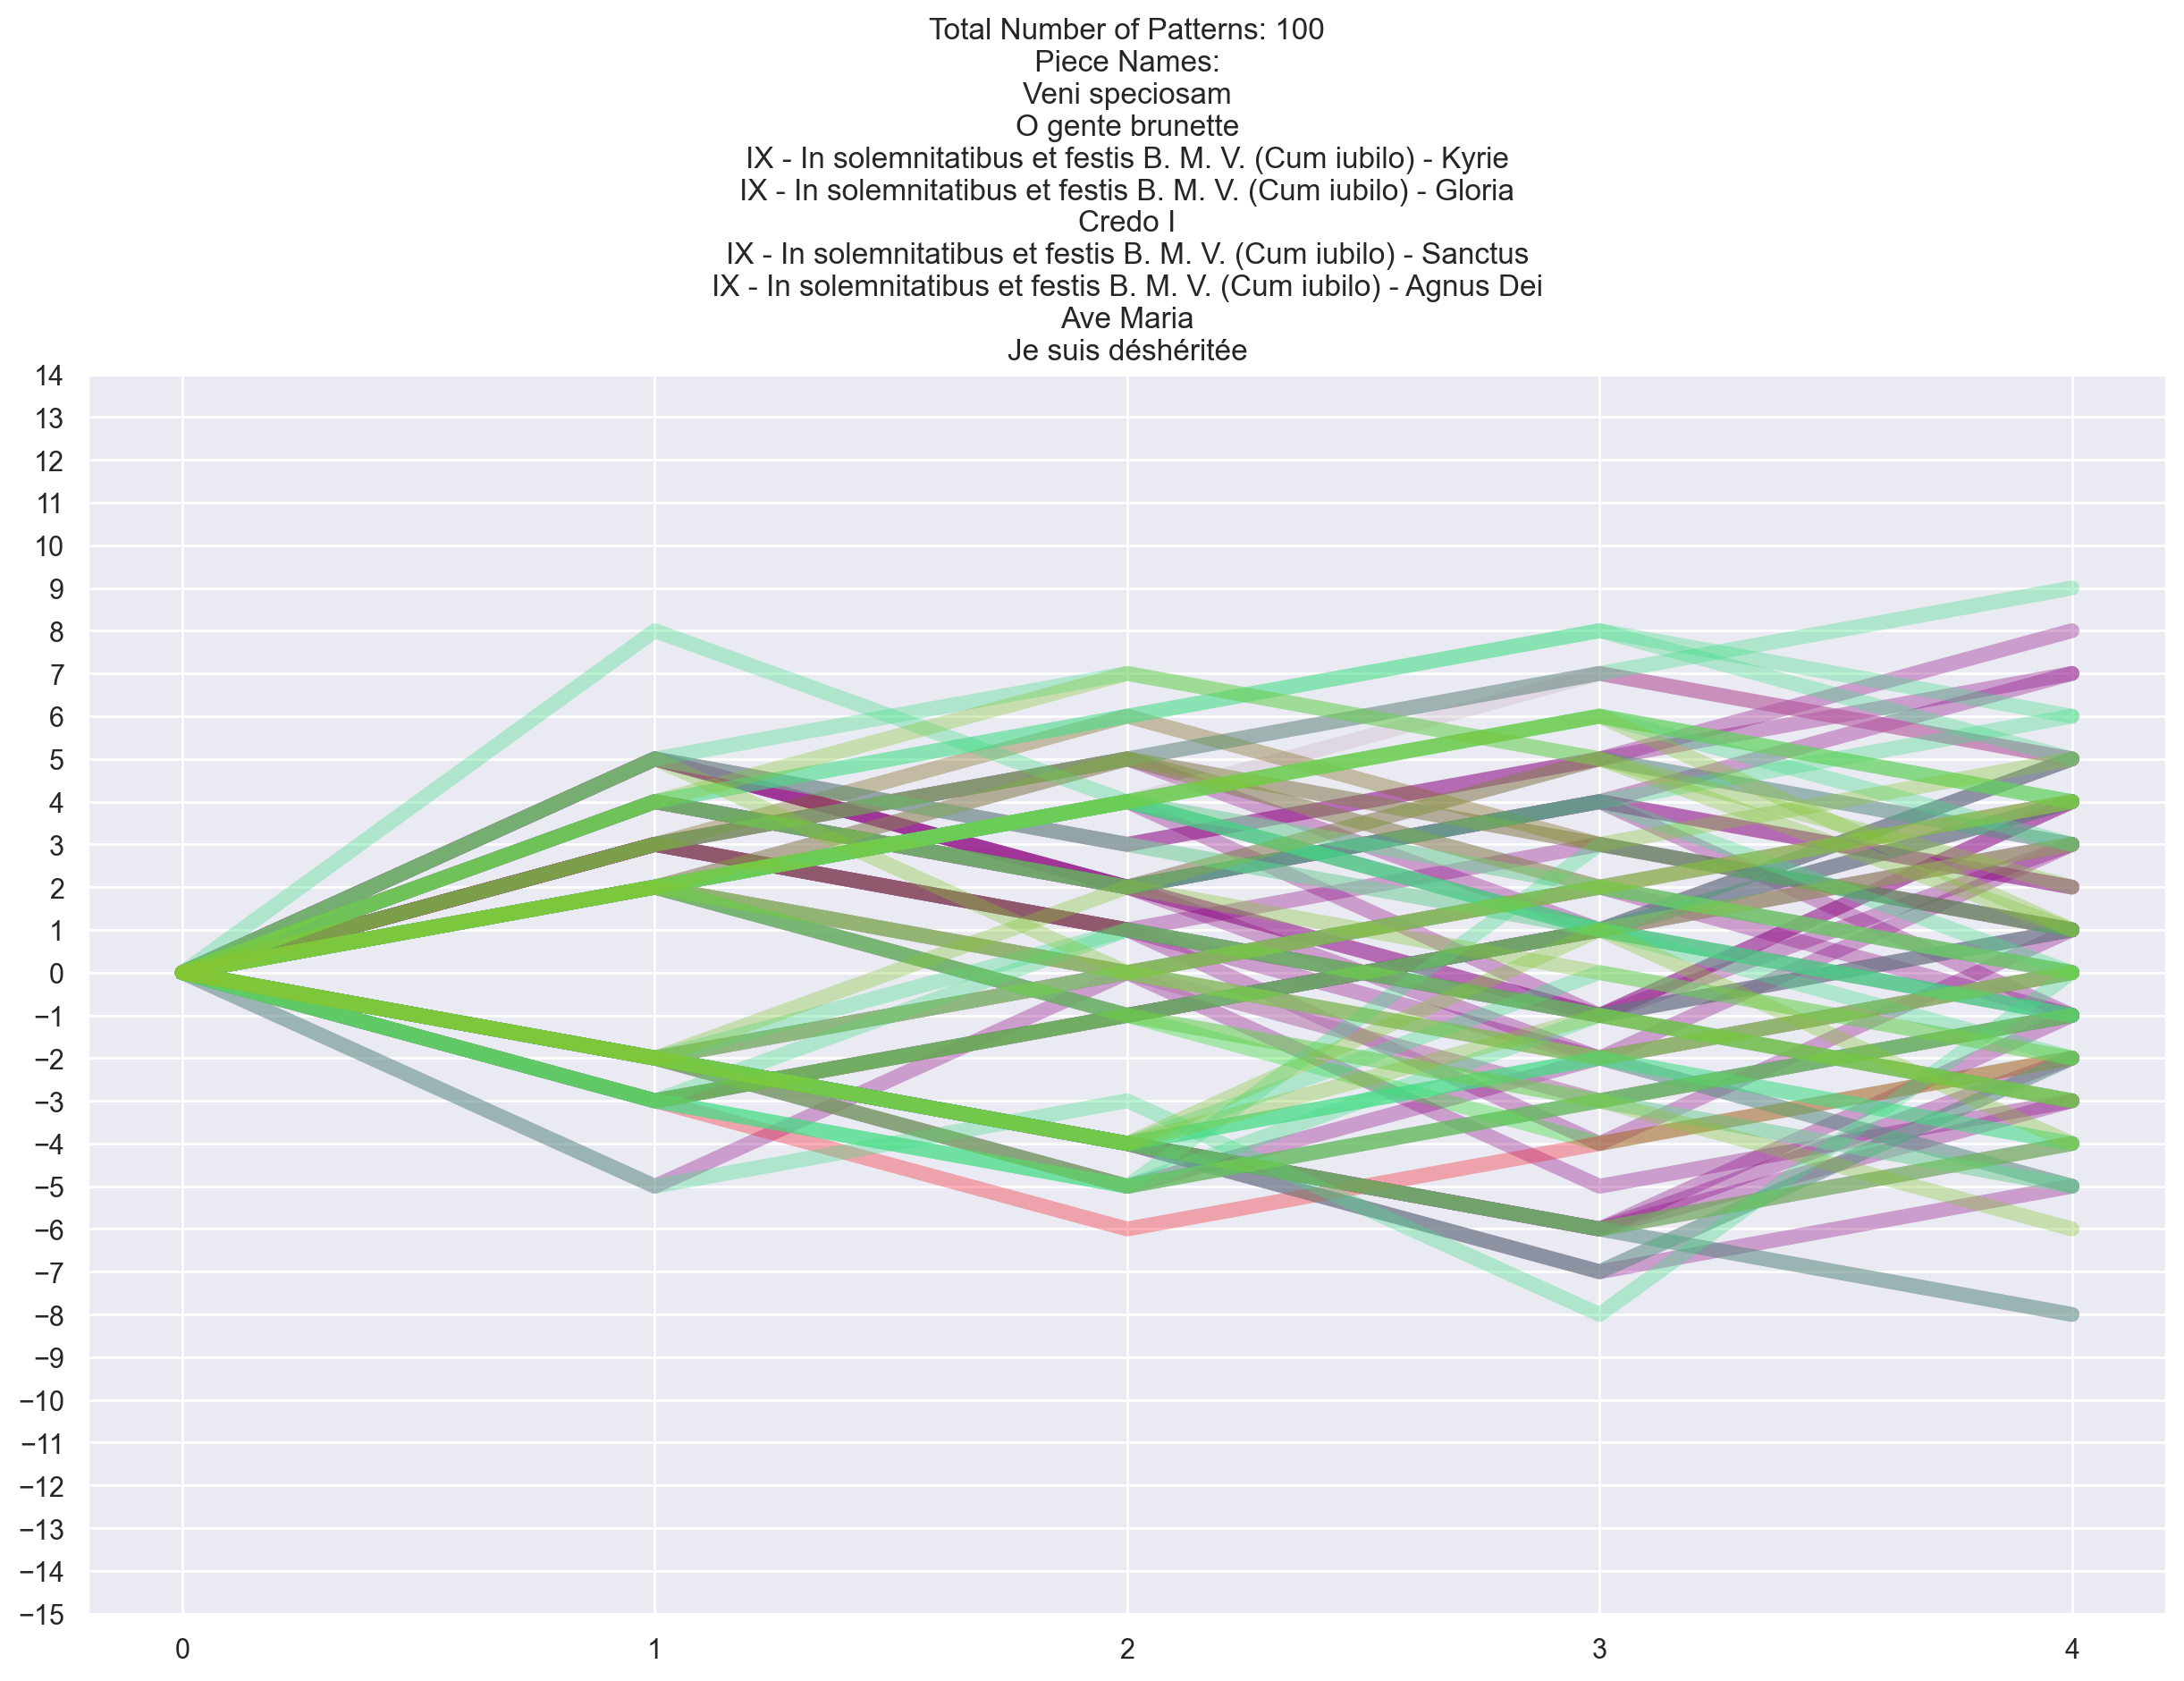

In [20]:
compareIntervalFamilies(piece_corpus, 4, variableLength=False, useEntries=True)